
# Datathon – EDA (v3) • Applicants, Prospects e Vagas

Agora com `flatten_vagas()` baseado no schema enviado. Este notebook:
- Faz **flatten** de `applicants.json`, `prospects.json` e `vagas.json`.
- Faz *joins*:
  - `prospects.codigo` ↔ `applicants.codigo_profissional`
  - `prospects.vaga_id` ↔ `vagas.vaga_id`
- Cria descritivas por **estado/cidade**, **nível**, **tipo de contratação**, **analista responsável**, etc.


## 1) Setup

In [1]:

from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

pd.set_option("display.max_columns", 160)
pd.set_option("display.width", 160)

DATA_DIR = Path("../data/raw")
APPLICANTS = DATA_DIR / "applicants.json"
PROSPECTS  = DATA_DIR / "prospects.json"
VAGAS      = DATA_DIR / "vagas.json"

APPLICANTS, PROSPECTS, VAGAS


Matplotlib is building the font cache; this may take a moment.


(PosixPath('../data/raw/applicants.json'),
 PosixPath('../data/raw/prospects.json'),
 PosixPath('../data/raw/vagas.json'))

## 2) Funções de carregamento e *flatten*

In [2]:

def load_json(path: Path):
    if not path.exists():
        print(f"[AVISO] Não encontrado: {path.resolve()}")
        return None
    try:
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    except Exception as e:
        print(f"[ERRO] Falha ao ler {path.name}: {e}")
        return None

def flatten_applicants(raw_dict: dict) -> pd.DataFrame:
    if not isinstance(raw_dict, dict):
        return pd.DataFrame()
    rows = []
    for codigo, dados in raw_dict.items():
        flat = {"codigo_profissional": str(codigo)}
        if isinstance(dados, dict):
            for bloco, conteudo in dados.items():
                if isinstance(conteudo, dict):
                    for k, v in conteudo.items():
                        flat[f"{bloco}.{k}"] = v
                else:
                    flat[bloco] = conteudo
        rows.append(flat)
    df = pd.DataFrame(rows)
    # normalizações úteis
    # pega um campo de nome padronizado para o candidato
    for col in ["infos_basicas.nome","informacoes_pessoais.nome"]:
        if col in df.columns:
            df["nome_candidato"] = df[col]
            break
    return df

def flatten_prospects(raw_dict: dict) -> pd.DataFrame:
    if not isinstance(raw_dict, dict):
        return pd.DataFrame()
    rows = []
    for vaga_id, vaga in raw_dict.items():
        titulo = None
        modalidade = None
        prospects = []
        if isinstance(vaga, dict):
            titulo = vaga.get("titulo")
            modalidade = vaga.get("modalidade")
            prospects = vaga.get("prospects", []) or []
        if not isinstance(prospects, list):
            continue
        for p in prospects:
            rec = dict(p)
            rec["vaga_id"] = str(vaga_id)
            rec["vaga_titulo"] = titulo
            rec["vaga_modalidade"] = modalidade
            if "codigo" in rec and pd.notna(rec["codigo"]):
                rec["codigo"] = str(rec["codigo"]).strip()
            rows.append(rec)
    df = pd.DataFrame(rows)
    if "situacao_candidado" in df.columns:
        df.rename(columns={"situacao_candidado": "situacao_candidato"}, inplace=True)
    # parse datas
    for c in ["data_candidatura","ultima_atualizacao"]:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], format="%d-%m-%Y", errors="coerce")
    return df

def flatten_vagas(raw_dict: dict) -> pd.DataFrame:
    """
    Esperado: { "5185": { "informacoes_basicas": {...}, "perfil_vaga": {...}, "beneficios": {...} }, ...}
    Saída: uma linha por vaga, com colunas flatten e 'vaga_id'.
    """
    if not isinstance(raw_dict, dict):
        return pd.DataFrame()
    rows = []
    for vaga_id, dados in raw_dict.items():
        flat = {"vaga_id": str(vaga_id)}
        if isinstance(dados, dict):
            for bloco, conteudo in dados.items():
                if isinstance(conteudo, dict):
                    for k, v in conteudo.items():
                        flat[f"{bloco}.{k}"] = v
                else:
                    flat[bloco] = conteudo
        rows.append(flat)
    df = pd.DataFrame(rows)
    # normalizar nomes de colunas: trocar espaços por underscore
    df.columns = [c.replace(" ", "_") for c in df.columns]
    # datas
    for c in ["informacoes_basicas.data_requicisao", "informacoes_basicas.limite_esperado_para_contratacao"]:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], format="%d-%m-%Y", errors="coerce")
    # alias para campos úteis
    if "informacoes_basicas.titulo_vaga" in df.columns:
        df["titulo_vaga"] = df["informacoes_basicas.titulo_vaga"]
    if "perfil_vaga.estado" in df.columns:
        df["estado"] = df["perfil_vaga.estado"]
    if "perfil_vaga.cidade" in df.columns:
        df["cidade"] = df["perfil_vaga.cidade"]
    if "informacoes_basicas.tipo_contratacao" in df.columns:
        df["tipo_contratacao"] = df["informacoes_basicas.tipo_contratacao"]
    if "informacoes_basicas.analista_responsavel" in df.columns:
        df["analista_responsavel"] = df["informacoes_basicas.analista_responsavel"]
    # corrigir chave com espaço "nivel profissional"
    if "perfil_vaga.nivel_profissional" not in df.columns and "perfil_vaga.nivel_profissional" not in df.columns:
        # após replace space->underscore, o campo vira "perfil_vaga.nivel_profissional" se existia
        pass
    return df

def quick_info(df: pd.DataFrame, name: str):
    print(f"=== {name} ===")
    print("shape:", df.shape)
    if not df.empty:
        display(df.head(3))
        print("\nTipos:")
        print(df.dtypes)
    else:
        print("DataFrame vazio.")
    print("-"*80)

raw_app = load_json(APPLICANTS)
raw_pro = load_json(PROSPECTS)
raw_vag = load_json(VAGAS)

df_app = flatten_applicants(raw_app) if raw_app is not None else pd.DataFrame()
df_pro = flatten_prospects(raw_pro) if raw_pro is not None else pd.DataFrame()
df_vag = flatten_vagas(raw_vag) if raw_vag is not None else pd.DataFrame()

quick_info(df_app, "Applicants (flatten)")

=== Applicants (flatten) ===
shape: (42482, 59)


,codigo_profissional,infos_basicas.telefone_recado,infos_basicas.telefone,infos_basicas.objetivo_profissional,infos_basicas.data_criacao,infos_basicas.inserido_por,infos_basicas.email,infos_basicas.local,infos_basicas.sabendo_de_nos_por,infos_basicas.data_atualizacao,infos_basicas.codigo_profissional,infos_basicas.nome,informacoes_pessoais.data_aceite,informacoes_pessoais.nome,informacoes_pessoais.cpf,informacoes_pessoais.fonte_indicacao,informacoes_pessoais.email,informacoes_pessoais.email_secundario,informacoes_pessoais.data_nascimento,informacoes_pessoais.telefone_celular,informacoes_pessoais.telefone_recado,informacoes_pessoais.sexo,informacoes_pessoais.estado_civil,informacoes_pessoais.pcd,informacoes_pessoais.endereco,informacoes_pessoais.skype,informacoes_pessoais.url_linkedin,informacoes_pessoais.facebook,informacoes_profissionais.titulo_profissional,informacoes_profissionais.area_atuacao,informacoes_profissionais.conhecimentos_tecnicos,informacoes_profissionais.certificacoes,informacoes_profissionais.outras_certificacoes,informacoes_profissionais.remuneracao,informacoes_profissionais.nivel_profissional,formacao_e_idiomas.nivel_academico,formacao_e_idiomas.nivel_ingles,formacao_e_idiomas.nivel_espanhol,formacao_e_idiomas.outro_idioma,cv_pt,cv_en,formacao_e_idiomas.instituicao_ensino_superior,formacao_e_idiomas.cursos,formacao_e_idiomas.ano_conclusao,informacoes_pessoais.download_cv,informacoes_profissionais.qualificacoes,informacoes_profissionais.experiencias,formacao_e_idiomas.outro_curso,cargo_atual.id_ibrati,cargo_atual.email_corporativo,cargo_atual.cargo_atual,cargo_atual.projeto_atual,cargo_atual.cliente,cargo_atual.unidade,cargo_atual.data_admissao,cargo_atual.data_ultima_promocao,cargo_atual.nome_superior_imediato,cargo_atual.email_superior_imediato,nome_candidato
0,31000,,(11) 97048-2708,,10-11-2021 07:29:49,Luna Correia,carolina_aparecida@gmail.com,,,10-11-2021 07:29:49,31000,Carolina Aparecida,Cadastro anterior ao registro de aceite,Carolina Aparecida,,:,carolina_aparecida@gmail.com,,0000-00-00,(11) 97048-2708,,,,,,,,,,,,,,,,,,,-,assistente administrativo\n\n\nsantosbatista\n...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Carolina Aparecida
1,31001,,(11) 93723-4396,Analista Administrativo,10-11-2021 08:56:16,Laura Pacheco,eduardo_rios@hotmail.com,"São Paulo, São Paulo",Outros,11-11-2021 11:10:31,31001,Eduardo Rios,Cadastro anterior ao registro de aceite,Eduardo Rios,,Outros: Contato do RH,eduardo_rios@hotmail.com,,28-12-1994,(11) 93723-4396,,Feminino,Solteiro,Não,são paulo,,,,Analista Administrativo,Administrativa,,,,1900,,Ensino Superior Incompleto,Nenhum,Nenhum,-,formação acadêmica\nensino médio (2º grau) em ...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Eduardo Rios
2,31002,,(11) 92399-9824,Administrativo | Financeiro,10-11-2021 09:01:00,Laura Pacheco,pedro_henrique_carvalho@gmail.com,"São Paulo, São Paulo",Anúncio,10-11-2021 11:42:36,31002,Pedro Henrique Carvalho,Cadastro anterior ao registro de aceite,Pedro Henrique Carvalho,,Anúncio:,pedro_henrique_carvalho@gmail.com,,12-12-1988,(11) 92399-9824,,Feminino,Solteiro,Não,são paulo,,,,Administrativo | Financeiro,Administrativa,,"MS [77-418] MOS: Microsoft Office Word 2013, M...",,"2.500,00",,Ensino Superior Completo,Intermediário,Básico,Português - Fluente,objetivo: área administrativa | financeira\n\n...,,,Administração de Empresas,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pedro Henrique Carvalho



Tipos:
codigo_profissional                                 object
infos_basicas.telefone_recado                       object
infos_basicas.telefone                              object
infos_basicas.objetivo_profissional                 object
infos_basicas.data_criacao                          object
infos_basicas.inserido_por                          object
infos_basicas.email                                 object
infos_basicas.local                                 object
infos_basicas.sabendo_de_nos_por                    object
infos_basicas.data_atualizacao                      object
infos_basicas.codigo_profissional                   object
infos_basicas.nome                                  object
informacoes_pessoais.data_aceite                    object
informacoes_pessoais.nome                           object
informacoes_pessoais.cpf                            object
informacoes_pessoais.fonte_indicacao                object
informacoes_pessoais.email                      

In [ ]:
#Salvando csv
# DATA_DIR = Path("../data/raw")
# APPLICANTS = DATA_DIR / "applicants.csv"
# PROSPECTS  = DATA_DIR / "prospects.csv"
# VAGAS      = DATA_DIR / "vagas.csv"

# df_app.head(20000).to_csv(APPLICANTS)
# df_pro.to_csv(PROSPECTS)
# df_vag.to_csv(VAGAS)

In [21]:
quick_info(df_pro, "Prospects (flatten)")

=== Prospects (flatten) ===
shape: (53759, 10)


,nome,codigo,situacao_candidato,data_candidatura,ultima_atualizacao,comentario,recrutador,vaga_id,vaga_titulo,vaga_modalidade
0,José Vieira,25632,Encaminhado ao Requisitante,2021-03-25,2021-03-25,"Encaminhado para - PJ R$ 72,00/hora",Ana Lívia Moreira,4530,CONSULTOR CONTROL M,
1,Srta. Isabela Cavalcante,25529,Encaminhado ao Requisitante,2021-03-22,2021-03-23,"encaminhado para - R$ 6.000,00 – CLT Full , n...",Ana Lívia Moreira,4530,CONSULTOR CONTROL M,
2,Sra. Yasmin Fernandes,25364,Contratado pela Decision,2021-03-17,2021-04-12,Data de Inicio: 12/04/2021,Juliana Cassiano,4531,2021-2607395-PeopleSoft Application Engine-Dom...,



Tipos:
nome                          object
codigo                        object
situacao_candidato            object
data_candidatura      datetime64[ns]
ultima_atualizacao    datetime64[ns]
comentario                    object
recrutador                    object
vaga_id                       object
vaga_titulo                   object
vaga_modalidade               object
dtype: object
--------------------------------------------------------------------------------


In [23]:
quick_info(df_vag, "Vagas (flatten)")

=== Vagas (flatten) ===
shape: (14081, 50)


,vaga_id,informacoes_basicas.data_requicisao,informacoes_basicas.limite_esperado_para_contratacao,informacoes_basicas.titulo_vaga,informacoes_basicas.vaga_sap,informacoes_basicas.cliente,informacoes_basicas.solicitante_cliente,informacoes_basicas.empresa_divisao,informacoes_basicas.requisitante,informacoes_basicas.analista_responsavel,informacoes_basicas.tipo_contratacao,informacoes_basicas.prazo_contratacao,informacoes_basicas.objetivo_vaga,informacoes_basicas.prioridade_vaga,informacoes_basicas.origem_vaga,informacoes_basicas.superior_imediato,informacoes_basicas.nome,informacoes_basicas.telefone,perfil_vaga.pais,perfil_vaga.estado,perfil_vaga.cidade,perfil_vaga.bairro,perfil_vaga.regiao,perfil_vaga.local_trabalho,perfil_vaga.vaga_especifica_para_pcd,perfil_vaga.faixa_etaria,perfil_vaga.horario_trabalho,perfil_vaga.nivel_profissional,perfil_vaga.nivel_academico,perfil_vaga.nivel_ingles,perfil_vaga.nivel_espanhol,perfil_vaga.outro_idioma,perfil_vaga.areas_atuacao,perfil_vaga.principais_atividades,perfil_vaga.competencia_tecnicas_e_comportamentais,perfil_vaga.demais_observacoes,perfil_vaga.viagens_requeridas,perfil_vaga.equipamentos_necessarios,beneficios.valor_venda,beneficios.valor_compra_1,beneficios.valor_compra_2,informacoes_basicas.data_inicial,informacoes_basicas.data_final,perfil_vaga.habilidades_comportamentais_necessarias,informacoes_basicas.nome_substituto,titulo_vaga,estado,cidade,tipo_contratacao,analista_responsavel
0,5185,2021-05-04,NaT,Operation Lead -,Não,"Morris, Moran and Dodson",Dra. Catarina Marques,Decision São Paulo,Maria Laura Nogueira,Srta. Bella Ferreira,CLT Full,,,,,Superior Imediato:,,,Brasil,São Paulo,São Paulo,,,2000,Não,De: Até:,,Sênior,Ensino Superior Completo,Avançado,Fluente,,TI - Sistemas e Ferramentas-,Operations Lead\n\nRoles & Responsibilities:\n...,Required Skills:\n• Prior experience in Cloud ...,100% Remoto Período – entre 5 – 6 meses,,Nenhum -,-,R$,,NaN,NaN,NaN,NaN,Operation Lead -,São Paulo,São Paulo,CLT Full,Srta. Bella Ferreira
1,5184,2021-05-04,NaT,Consultor PP/QM Sênior,Não,"Morris, Moran and Dodson",Dra. Catarina Marques,Decision São Paulo,Maria Laura Nogueira,Yasmin da Rosa,CLT Full,,Contratação,,,Superior Imediato:,,,Brasil,São Paulo,São Paulo,,,2000,Não,De: Até:,,Sênior,Ensino Superior Completo,Fluente,Nenhum,,TI - Desenvolvimento/Programação-,Consultor PP/QM Sr.\n\n• Consultor PP/QM Sênio...,• Consultor PP/QM Sênior com experiencia em pr...,• Início: Imediato • Fim: Jan/22,,Nenhum -,-,R$,,NaN,NaN,NaN,NaN,Consultor PP/QM Sênior,São Paulo,São Paulo,CLT Full,Yasmin da Rosa
2,5183,2021-05-04,NaT,ANALISTA PL/JR C/ SQL,Não,"Morris, Moran and Dodson",Dra. Catarina Marques,Decision São Paulo,Maria Laura Nogueira,Ana Albuquerque,CLT Full,,RFP,,,Superior Imediato:,,,Brasil,São Paulo,São Paulo,,,2000,Não,De: Até:,,Analista,Ensino Superior Completo,Nenhum,Intermediário,,TI - Sistemas e Ferramentas-,Descrição – Atividades:\n\no Monitoramento das...,Requisitos mandatórios:\n\no Conhecimentos Téc...,Localização: Remoto Perfil: Analista Pleno ou ...,,Nenhum -,-,R$,,NaN,NaN,NaN,NaN,ANALISTA PL/JR C/ SQL,São Paulo,São Paulo,CLT Full,Ana Albuquerque



Tipos:
vaga_id                                                         object
informacoes_basicas.data_requicisao                     datetime64[ns]
informacoes_basicas.limite_esperado_para_contratacao    datetime64[ns]
informacoes_basicas.titulo_vaga                                 object
informacoes_basicas.vaga_sap                                    object
informacoes_basicas.cliente                                     object
informacoes_basicas.solicitante_cliente                         object
informacoes_basicas.empresa_divisao                             object
informacoes_basicas.requisitante                                object
informacoes_basicas.analista_responsavel                        object
informacoes_basicas.tipo_contratacao                            object
informacoes_basicas.prazo_contratacao                           object
informacoes_basicas.objetivo_vaga                               object
informacoes_basicas.prioridade_vaga                             objec

## 3) Valores ausentes (Top 30)

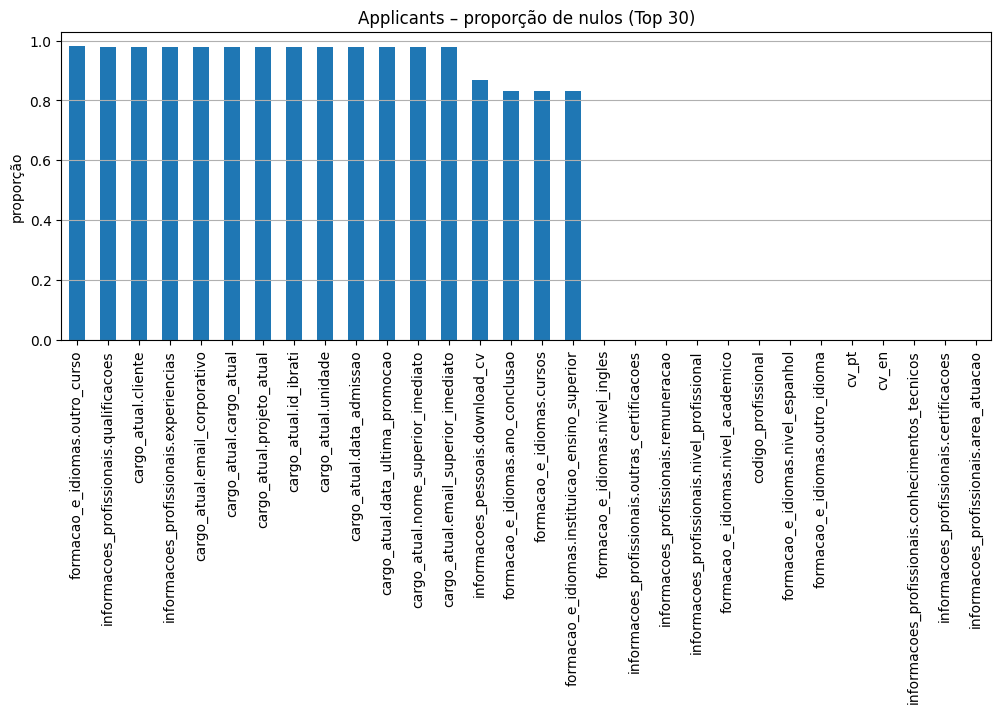

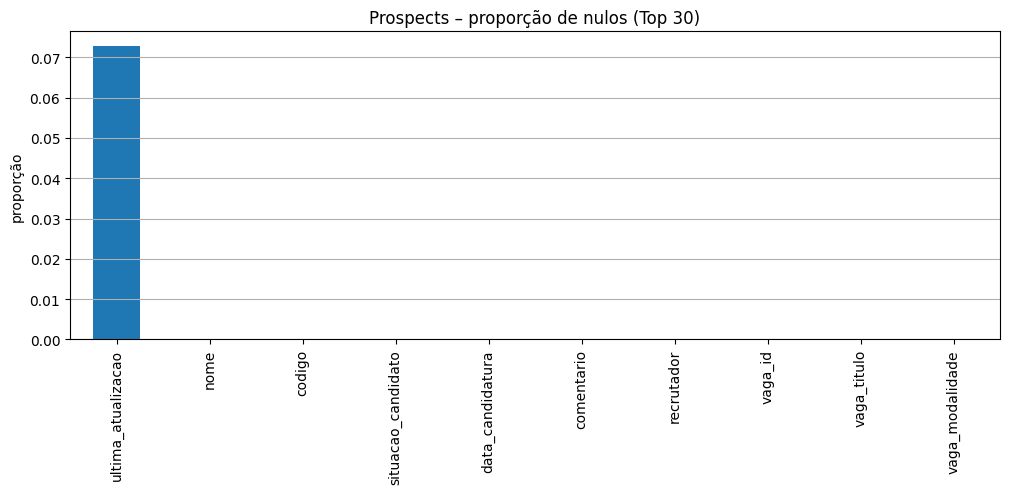

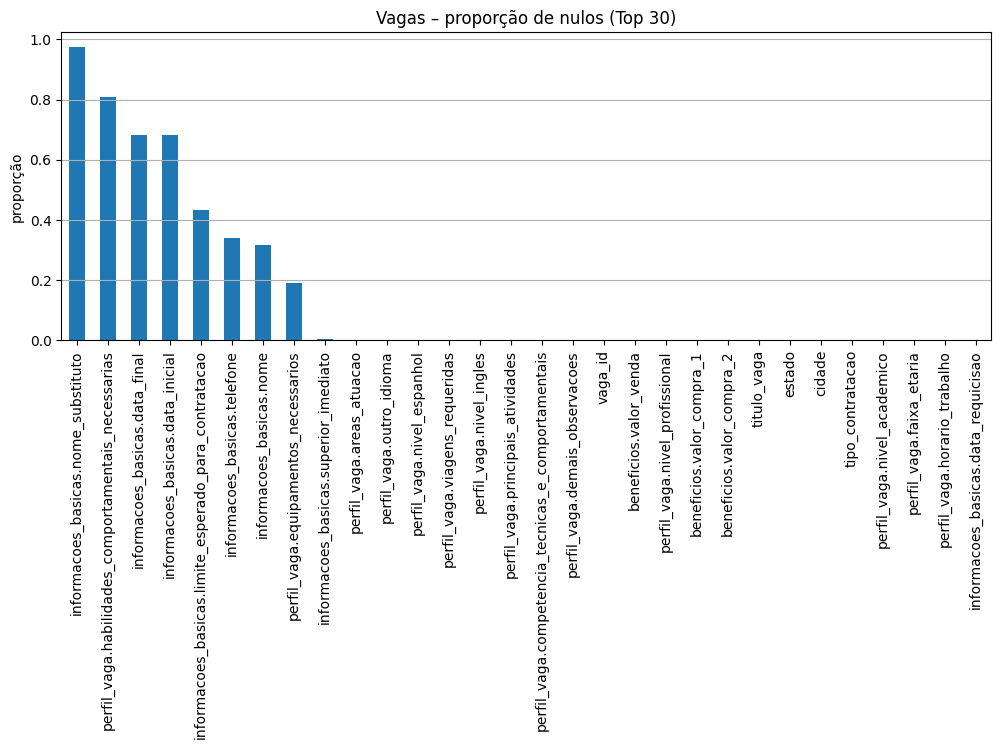

In [5]:

def plot_missing(df: pd.DataFrame, title: str):
    if df.empty:
        print(f"[SKIP] {title}: df vazio.")
        return
    miss = df.isna().mean().sort_values(ascending=False).head(30)
    ax = miss.plot(kind="bar", figsize=(12,4))
    ax.set_title(f"{title} – proporção de nulos (Top 30)")
    ax.set_ylabel("proporção")
    ax.grid(True, axis="y")
    plt.show()

plot_missing(df_app, "Applicants")
plot_missing(df_pro, "Prospects")
plot_missing(df_vag, "Vagas")


## 4) Joins: Prospects ↔ Applicants ↔ Vagas

In [6]:

df_join_pa = pd.DataFrame()
df_full = pd.DataFrame()

if not df_pro.empty and not df_app.empty:
    df_app["codigo_profissional"] = df_app["codigo_profissional"].astype(str)
    df_pro["codigo"] = df_pro["codigo"].astype(str)
    df_join_pa = df_pro.merge(df_app, left_on="codigo", right_on="codigo_profissional", how="left", suffixes=("_pro","_app"))
    print("Join Prospects-Applicants:", df_join_pa.shape)

if not df_join_pa.empty and not df_vag.empty:
    df_full = df_join_pa.merge(df_vag, on="vaga_id", how="left", suffixes=("","_vaga"))
    print("Join completo (Prospects-Applicants-Vagas):", df_full.shape)

display(df_full.head(3))


Join Prospects-Applicants: (53759, 69)
Join completo (Prospects-Applicants-Vagas): (53759, 118)


,nome,codigo,situacao_candidato,data_candidatura,ultima_atualizacao,comentario,recrutador,vaga_id,vaga_titulo,vaga_modalidade,codigo_profissional,infos_basicas.telefone_recado,infos_basicas.telefone,infos_basicas.objetivo_profissional,infos_basicas.data_criacao,infos_basicas.inserido_por,infos_basicas.email,infos_basicas.local,infos_basicas.sabendo_de_nos_por,infos_basicas.data_atualizacao,infos_basicas.codigo_profissional,infos_basicas.nome,informacoes_pessoais.data_aceite,informacoes_pessoais.nome,informacoes_pessoais.cpf,informacoes_pessoais.fonte_indicacao,informacoes_pessoais.email,informacoes_pessoais.email_secundario,informacoes_pessoais.data_nascimento,informacoes_pessoais.telefone_celular,informacoes_pessoais.telefone_recado,informacoes_pessoais.sexo,informacoes_pessoais.estado_civil,informacoes_pessoais.pcd,informacoes_pessoais.endereco,informacoes_pessoais.skype,informacoes_pessoais.url_linkedin,informacoes_pessoais.facebook,informacoes_profissionais.titulo_profissional,informacoes_profissionais.area_atuacao,informacoes_profissionais.conhecimentos_tecnicos,informacoes_profissionais.certificacoes,informacoes_profissionais.outras_certificacoes,informacoes_profissionais.remuneracao,informacoes_profissionais.nivel_profissional,formacao_e_idiomas.nivel_academico,formacao_e_idiomas.nivel_ingles,formacao_e_idiomas.nivel_espanhol,formacao_e_idiomas.outro_idioma,cv_pt,cv_en,formacao_e_idiomas.instituicao_ensino_superior,formacao_e_idiomas.cursos,formacao_e_idiomas.ano_conclusao,informacoes_pessoais.download_cv,informacoes_profissionais.qualificacoes,informacoes_profissionais.experiencias,formacao_e_idiomas.outro_curso,cargo_atual.id_ibrati,cargo_atual.email_corporativo,cargo_atual.cargo_atual,cargo_atual.projeto_atual,cargo_atual.cliente,cargo_atual.unidade,cargo_atual.data_admissao,cargo_atual.data_ultima_promocao,cargo_atual.nome_superior_imediato,cargo_atual.email_superior_imediato,nome_candidato,informacoes_basicas.data_requicisao,informacoes_basicas.limite_esperado_para_contratacao,informacoes_basicas.titulo_vaga,informacoes_basicas.vaga_sap,informacoes_basicas.cliente,informacoes_basicas.solicitante_cliente,informacoes_basicas.empresa_divisao,informacoes_basicas.requisitante,informacoes_basicas.analista_responsavel,informacoes_basicas.tipo_contratacao,informacoes_basicas.prazo_contratacao,informacoes_basicas.objetivo_vaga,informacoes_basicas.prioridade_vaga,informacoes_basicas.origem_vaga,informacoes_basicas.superior_imediato,informacoes_basicas.nome,informacoes_basicas.telefone,perfil_vaga.pais,perfil_vaga.estado,perfil_vaga.cidade,perfil_vaga.bairro,perfil_vaga.regiao,perfil_vaga.local_trabalho,perfil_vaga.vaga_especifica_para_pcd,perfil_vaga.faixa_etaria,perfil_vaga.horario_trabalho,perfil_vaga.nivel_profissional,perfil_vaga.nivel_academico,perfil_vaga.nivel_ingles,perfil_vaga.nivel_espanhol,perfil_vaga.outro_idioma,perfil_vaga.areas_atuacao,perfil_vaga.principais_atividades,perfil_vaga.competencia_tecnicas_e_comportamentais,perfil_vaga.demais_observacoes,perfil_vaga.viagens_requeridas,perfil_vaga.equipamentos_necessarios,beneficios.valor_venda,beneficios.valor_compra_1,beneficios.valor_compra_2,informacoes_basicas.data_inicial,informacoes_basicas.data_final,perfil_vaga.habilidades_comportamentais_necessarias,informacoes_basicas.nome_substituto,titulo_vaga,estado,cidade,tipo_contratacao,analista_responsavel
0,José Vieira,25632,Encaminhado ao Requisitante,2021-03-25,2021-03-25,"Encaminhado para - PJ R$ 72,00/hora",Ana Lívia Moreira,4530,CONSULTOR CONTROL M,,25632,,(21) 93485-6494,,25-03-2021 13:36:19,Ana Lívia Moreira,josé_vieira@gmail.com,,,25-03-2021 13:36:19,25632,José Vieira,Cadastro anterior ao registro de aceite,José Vieira,,:,josé_vieira@gmail.com,,0000-00-00,(21) 93485-6494,,,,,,,,,,,,,,,,,,,-,\ndados pessoais\nestado civil: casado\nidade:...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,José Vieira,2021-03-10,NaT,CONSULTOR CONTROL M,Não,"Morris, Moran and Dodson",Dra. Catarina Marques,

## 5) Descritivas por Vagas

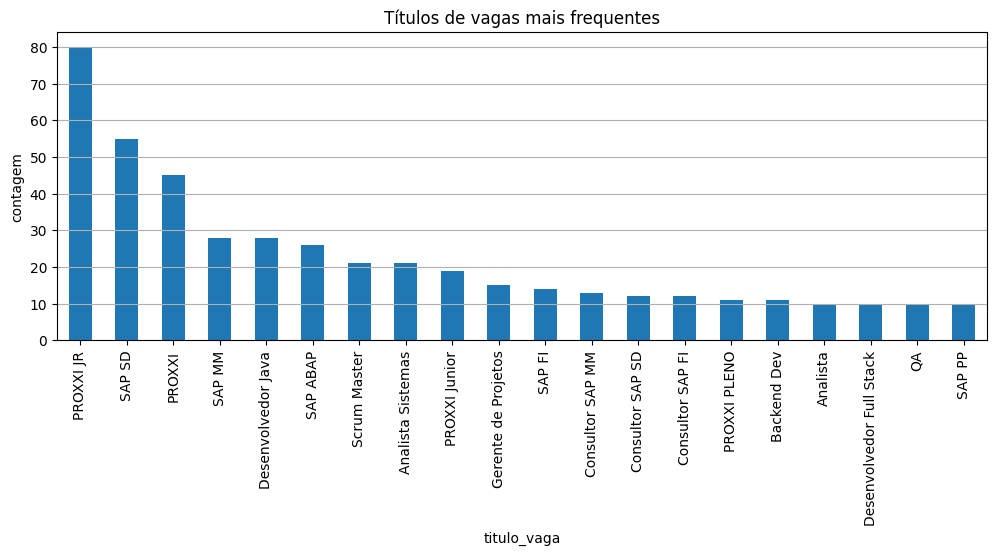

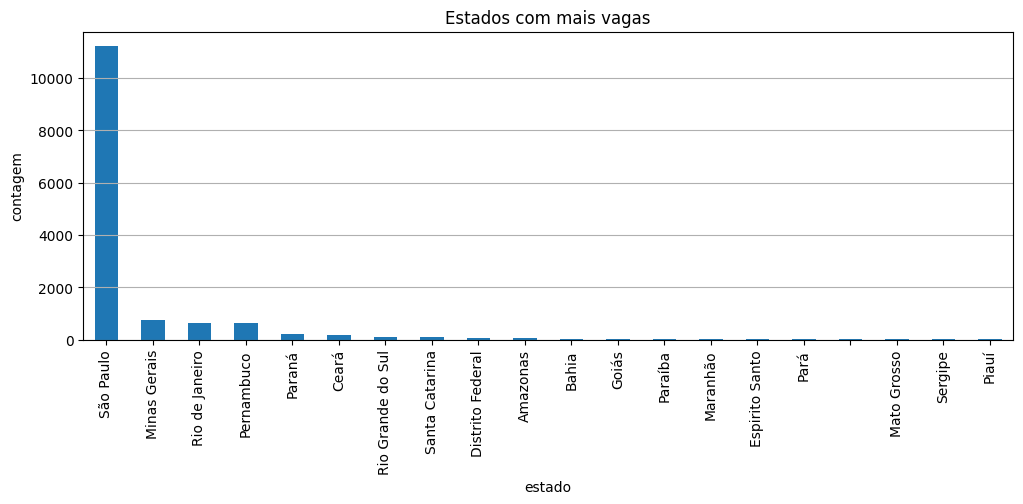

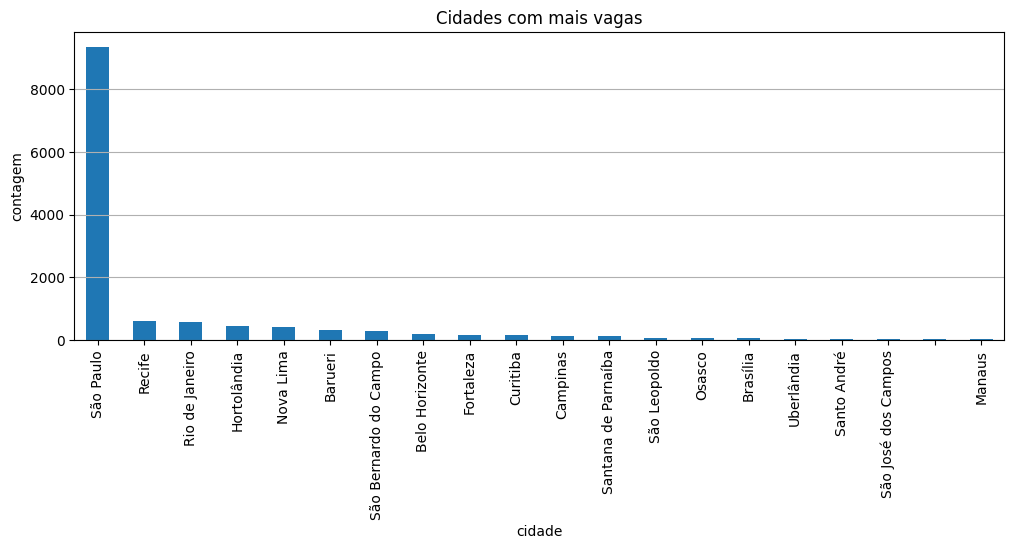

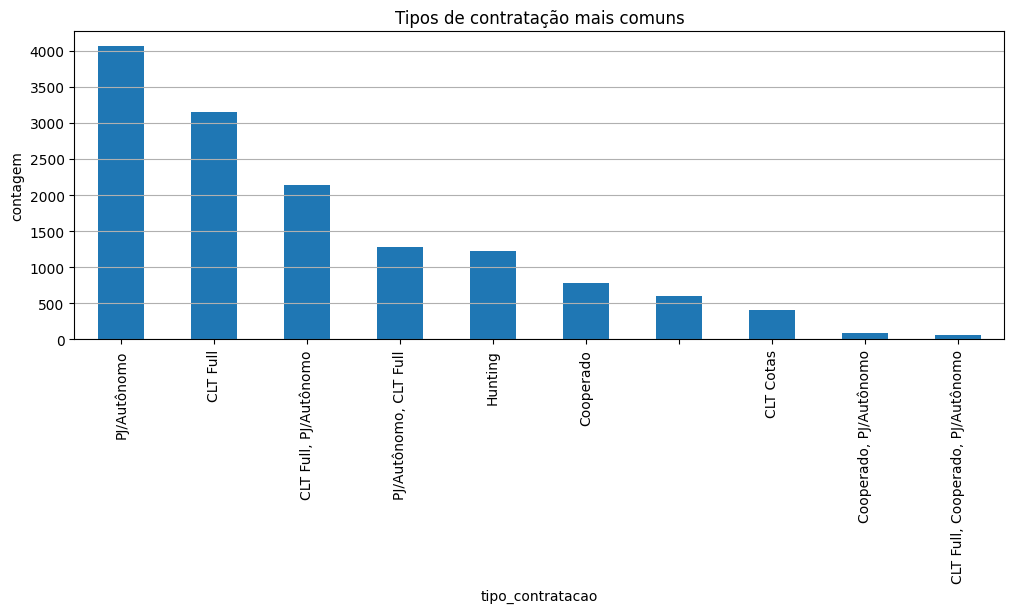

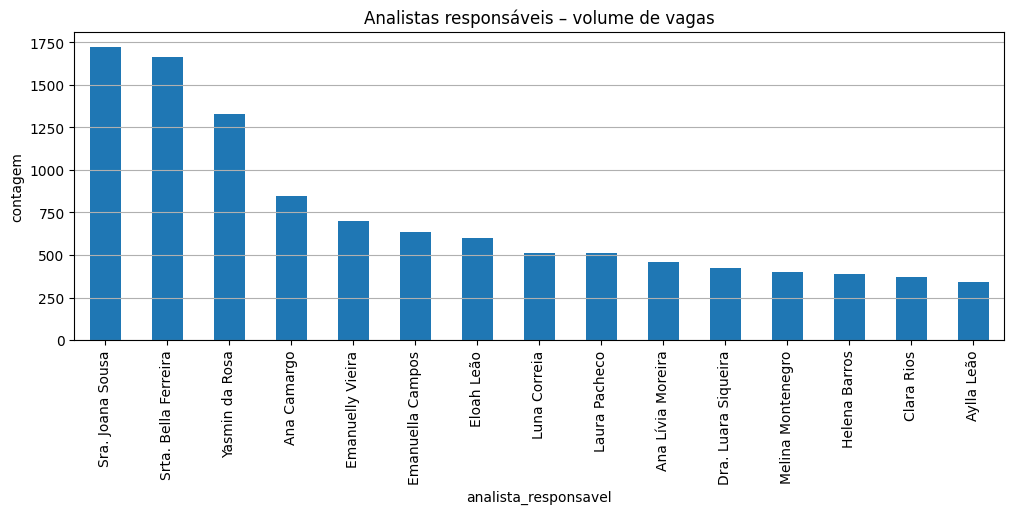

In [7]:

def top_counts(df, col, top=20, title=None):
    if df.empty or col not in df.columns:
        print(f"[SKIP] {col}")
        return
    vc = df[col].value_counts().head(top)
    ax = vc.plot(kind="bar", figsize=(12,4))
    ax.set_title(title or f"Top {top} – {col}")
    ax.set_ylabel("contagem")
    ax.grid(True, axis="y")
    plt.show()

# Em VAGAS
top_counts(df_vag, "titulo_vaga", 20, "Títulos de vagas mais frequentes")
top_counts(df_vag, "estado", 20, "Estados com mais vagas")
top_counts(df_vag, "cidade", 20, "Cidades com mais vagas")
top_counts(df_vag, "tipo_contratacao", 10, "Tipos de contratação mais comuns")
top_counts(df_vag, "analista_responsavel", 15, "Analistas responsáveis – volume de vagas")


## 6) Pipeline e Conversão por Vaga

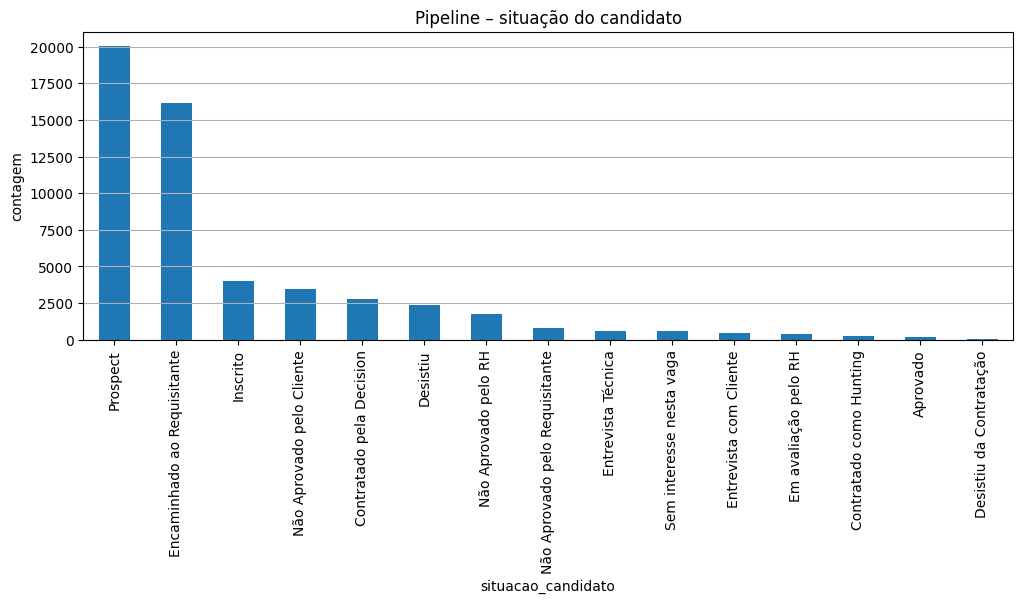

,total,contratados,taxa_conversao
vaga_id,,,
2031,1,1,1.0
1890,2,2,1.0
1878,1,1,1.0
1879,1,1,1.0
1880,1,1,1.0
1881,1,1,1.0
1882,1,1,1.0
1883,1,1,1.0
1884,1,1,1.0


In [20]:

if not df_pro.empty:
    top_counts(df_pro, "situacao_candidato", 15, "Pipeline – situação do candidato")
    conv = df_pro.copy()
    conv["_is_contratado"] = conv["situacao_candidato"].fillna("").str.lower().str.contains("contratado")
    agg = conv.groupby("vaga_id")["_is_contratado"].agg(["count","sum"]).rename(columns={"count":"total","sum":"contratados"})
    agg["taxa_conversao"] = agg["contratados"] / agg["total"]
    display(agg.sort_values("taxa_conversao", ascending=False).head(20))
else:
    print("[INFO] df_pro vazio para conversão.")


<Axes: ylabel='recrutador'>

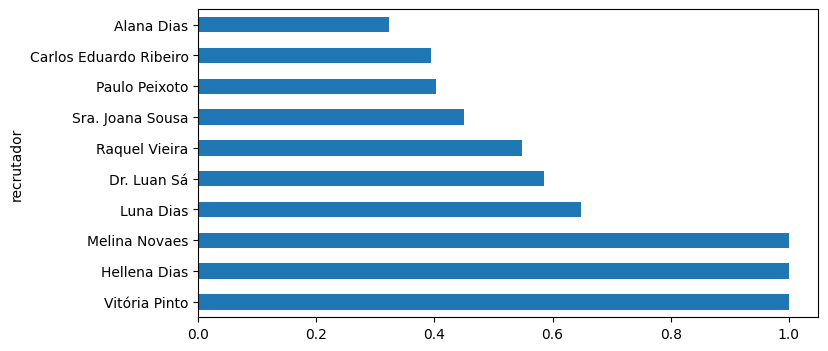

In [26]:
# Conversão por recrutador
conv_recrutador = (df_pro.assign(is_contratado=df_pro["situacao_candidato"].str.contains("contratado", case=False))
                   .groupby("recrutador")["is_contratado"].mean()
                   .sort_values(ascending=False))
conv_recrutador.head(10).plot(kind="barh", figsize=(8,4))

## 7) Candidaturas por dia (série temporal)

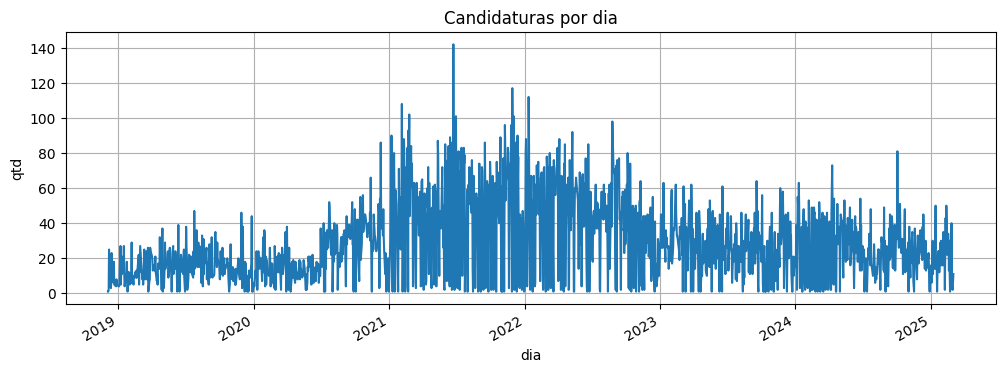

In [9]:

if not df_pro.empty and "data_candidatura" in df_pro.columns:
    ts = df_pro.dropna(subset=["data_candidatura"]).copy()
    ts["dia"] = ts["data_candidatura"].dt.to_period("D").dt.to_timestamp()
    daily = ts.groupby("dia").size().rename("candidaturas")
    ax = daily.plot(kind="line", figsize=(12,4))
    ax.set_title("Candidaturas por dia")
    ax.set_xlabel("dia")
    ax.set_ylabel("qtd")
    ax.grid(True, axis="both")
    plt.show()


## 8) Skills por texto (candidatos x vagas)

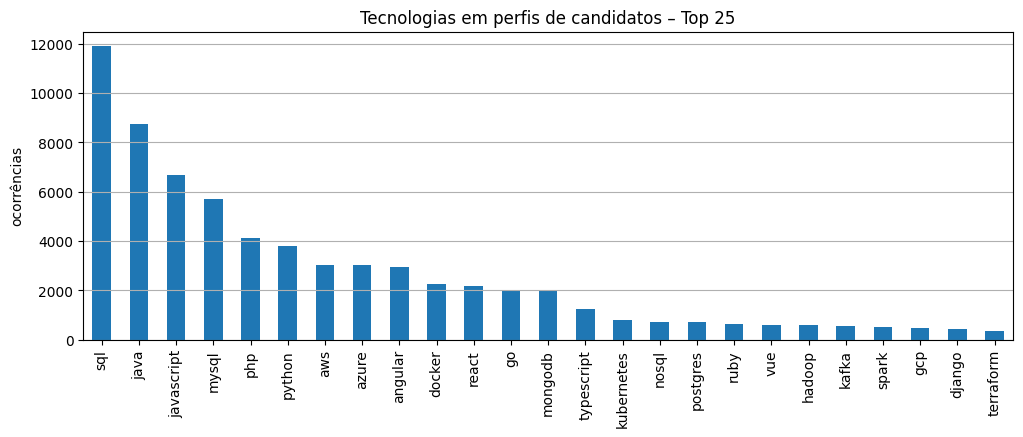

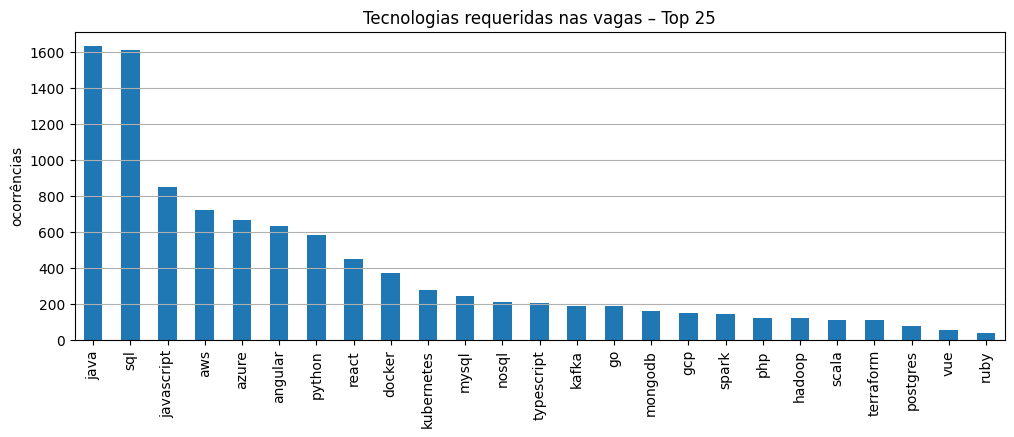

In [14]:
TECH_KEYWORDS = [
    "python","java","javascript","typescript","c#","c++","go","rust","ruby","php","scala",
    "sql","nosql","mysql","postgres","mongodb","spark","hadoop","kafka","airflow",
    "aws","gcp","azure","docker","kubernetes","terraform",
    "pandas","numpy","sklearn","pytorch","tensorflow","keras","xgboost","lightgbm",
    "fastapi","flask","django","react","vue","angular"
]

def freq_keywords(series: pd.Series, keywords):
    if series is None or series.empty:
        return pd.Series(dtype=int)
    text = series.fillna("").str.lower().astype(str)
    counts = {}
    for kw in keywords:
        pattern = r"\b" + re.escape(kw) + r"\b"   # <-- uso de re.escape
        counts[kw] = text.str.contains(pattern, regex=True).sum()
    return pd.Series(counts).sort_values(ascending=False)

# Texto dos candidatos
if not df_app.empty:
    cols_cand_text = [c for c in ["cv_pt","informacoes_profissionais.conhecimentos_tecnicos"] if c in df_app.columns]
    if cols_cand_text:
        cand_text = df_app[cols_cand_text].agg(lambda x: " ".join(x.astype(str)), axis=1)
        fc = freq_keywords(cand_text, TECH_KEYWORDS).head(25)
        ax = fc.plot(kind="bar", figsize=(12,4))
        ax.set_title("Tecnologias em perfis de candidatos – Top 25")
        ax.set_ylabel("ocorrências")
        ax.grid(True, axis="y")
        plt.show()

# Texto das vagas (descrição/competências/atividades)
vaga_text_cols = [c for c in [
    "perfil_vaga.principais_atividades",
    "perfil_vaga.competencia_tecnicas_e_comportamentais",
    "informacoes_basicas.objetivo_vaga"
] if c in df_vag.columns]

if not df_vag.empty and vaga_text_cols:
    vaga_text = df_vag[vaga_text_cols].agg(lambda x: " ".join(x.astype(str)), axis=1)
    fv = freq_keywords(vaga_text, TECH_KEYWORDS).head(25)
    ax = fv.plot(kind="bar", figsize=(12,4))
    ax.set_title("Tecnologias requeridas nas vagas – Top 25")
    ax.set_ylabel("ocorrências")
    ax.grid(True, axis="y")
    plt.show()


## 9) Esboço de *match* por keywords (vaga ↔ candidato) no join completo

,vaga_id,codigo,match_kw
0,4530,25632,0.000000
1,4530,25529,0.000000
2,4531,25364,0.000000
3,4531,25360,0.000000
4,4533,26338,0.142857
5,4533,24645,1.000000
6,4534,26361,0.400000
7,4534,26205,0.200000
8,4534,26003,0.333333
9,4534,25509,0.200000


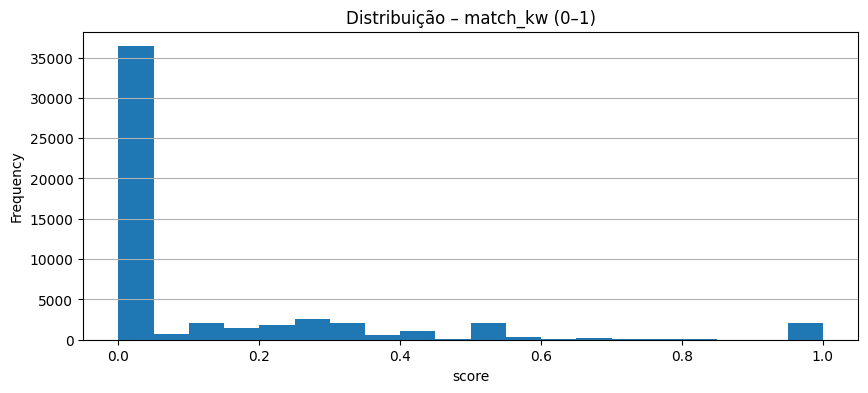

In [15]:

def overlap_score(a: str, b: str, keywords=TECH_KEYWORDS):
    if not isinstance(a, str) or not isinstance(b, str):
        return 0.0
    A = set([kw for kw in keywords if kw in a.lower()])
    B = set([kw for kw in keywords if kw in b.lower()])
    if not A and not B:
        return 0.0
    inter = len(A & B)
    union = len(A | B)
    return inter/union if union else 0.0

if not df_full.empty:
    cand_cols = [c for c in ["cv_pt","informacoes_profissionais.conhecimentos_tecnicos"] if c in df_full.columns]
    vaga_cols = [c for c in ["perfil_vaga.principais_atividades","perfil_vaga.competencia_tecnicas_e_comportamentais","vaga_titulo"] if c in df_full.columns]
    if cand_cols and vaga_cols:
        df_full["_cand_text"] = df_full[cand_cols].agg(lambda x: " ".join(x.astype(str)), axis=1)
        df_full["_vaga_text"] = df_full[vaga_cols].agg(lambda x: " ".join(x.astype(str)), axis=1)
        df_full["match_kw"] = df_full.apply(lambda r: overlap_score(r["_cand_text"], r["_vaga_text"]), axis=1)
        display(df_full[["vaga_id","codigo","match_kw"]].head(10))
        ax = df_full["match_kw"].plot(kind="hist", bins=20, figsize=(10,4))
        ax.set_title("Distribuição – match_kw (0–1)")
        ax.set_xlabel("score")
        ax.grid(True, axis="y")
        plt.show()


In [18]:
from ydata_profiling import ProfileReport

# Applicants
if not df_app.empty:
    profile_app = ProfileReport(
        df_app,
        title="Applicants Profiling Report",
        explorative=True,
        correlations={"pearson": {"calculate": False}}, # evita demorar demais
        minimal=True
    )
    profile_app.to_file("eda_applicants.html")
    print("✅ Relatório applicants salvo em eda_applicants.html")

# Prospects
if not df_pro.empty:
    profile_pro = ProfileReport(
        df_pro,
        title="Prospects Profiling Report",
        explorative=True,
        correlations={"pearson": {"calculate": False}},
        minimal=True
    )
    profile_pro.to_file("eda_prospects.html")
    print("✅ Relatório prospects salvo em eda_prospects.html")

# Vagas
if not df_vag.empty:
    profile_vag = ProfileReport(
        df_vag,
        title="Vagas Profiling Report",
        explorative=True,
        correlations={"pearson": {"calculate": False}},
        minimal=True
    )
    profile_vag.to_file("eda_vagas.html")
    print("✅ Relatório vagas salvo em eda_vagas.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Relatório applicants salvo em eda_applicants.html


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Relatório prospects salvo em eda_prospects.html


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Relatório vagas salvo em eda_vagas.html



## 10) Próximos passos
- Normalizar e mapear `situacao_candidato` para um funil padronizado (encaminhado → entrevista → oferta → contratado).
- Padronizar localidades (`estado`, `cidade`) e corrigir acentos/caixa.
- Enriquecer candidatos e vagas com embeddings semânticos (Sentence-Transformers) para *matching* robusto.
- Definir métricas offline (MAP@K, nDCG) se houver rótulos de contratação/shortlist.
